In [1]:
import pandas as pd
import numpy as np
from biom import Table
from skbio import OrdinationResults, TreeNode, DistanceMatrix
from gemelli.preprocessing import fast_unifrac, matrix_rclr
from skbio.stats.composition import closure
from gemelli.rpca import phylogenetic_rpca


import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import matplotlib


%matplotlib inline

def draw_painting_biplot(ordination, axis_1, axis_2):
    """Draws a biplot using Seaborn and Matplotlib.
    Parameters
    ----------
        ordination: skbio.OrdinationResults
            Biplot ordination created from apca() above.
        axis_1: str
            Name of the first Axis to draw in the biplot.
        axis_2: str
            Name of the second Axis to draw in the biplot.
    """

    fig, ax = plt.subplots(1,1,figsize=(5,5))

    V = ordination.samples
    U = ordination.features
    p = ordination.proportion_explained

    # Draw points using a Seaborn scatterplot
    
    cmap = {'Phenotype 1':'#377eb8',
            'Phenotype 2':'#4daf4a'}
    V['sample_map'] = ['Phenotype 1', 'Phenotype 1',
                       'Phenotype 2', 'Phenotype 2']
    sns.scatterplot(
        x=axis_1, y=axis_2, data=V, hue='sample_map', s = 100, alpha=.9,
        #color="#000000",
        palette=cmap, ax=ax
    )
    # add dot annotation
    for i in V.index:
        ax.text(V.loc[i, axis_1], V.loc[i, axis_2], str(i), fontproperties='arial',weight='bold', zorder=-1,fontsize=16)

    # add arrows
    acmap = {'A':['A','#aa0000'],
             'B':['B','#d40000'],
             'n2':['N2','#00aa44'],
             'C':['C','#d40055'],
             'D':['D','#aa0088'],
             'E':['E','#ff00cb'],
             'n6':['N8','#ff7f2a'],
             'n7':['N7','#918a6f'],
             'F':['F','#3771c8'],
             'G':['G','#0044aa'],
             'H':['H','#3737c8'],
             'I':['I','#6600ff'],
             'n12':['N6','#5aa02c'],
             'n13':['N5','#89a02c'],
             'J':['J','#37abc8'],
             'K':['K','#0088aa'],
             'n16':['N4','#008000'],
             'n17':['N3','#5aa02c'],
             'n18':['N2','#00aa44'],
             'n19':['N1','#2d5016']}
    annots = []
    seqs = []
    limits_x = []
    limits_y = []
    scale_ = 1.5
    for i in U.index:
        annots.append(ax.arrow(0, 0,
                               U.loc[i, axis_1] * scale_,
                               U.loc[i, axis_2] * scale_,
                               color=acmap[i][1],
                               alpha=0.8,
                               lw=0.75,
                               ec = "black",
                               length_includes_head=True,
                               head_width=.03, width=.009))
        limits_x.append(U.loc[i, axis_1] * scale_ + .2)
        limits_y.append(U.loc[i, axis_2] * scale_ + .2)
        ax.text(U.loc[i, axis_1] * scale_,
                U.loc[i, axis_2] * scale_,
                acmap[i][0], zorder=-1,fontproperties='arial',weight='bold',fontsize=16)
        seqs.append(i)
    
    # set axis limits
    ax.set_xlim(min(limits_x), max(limits_x))
    ax.set_ylim(min(limits_y), max(limits_y))

    # Hide grid lines
    ax.grid(False)
    
    ax.set_facecolor("#f0f0f0")
    
    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)
    
    # set the backrounf to be transparent
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.0)
    
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(8)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(8)


    # get axis labels
    ax.set_xlabel("%s (%.2f%%)" % (axis_1, p.loc[axis_1] * 100),fontproperties='arial',weight='bold',
                 fontsize=16, color="#000000")
    ax.set_ylabel("%s (%.2f%%)" % (axis_2, p.loc[axis_2] * 100),fontproperties='arial',weight='bold',
                 fontsize=16, color="#000000")
    return fig, ax


In [2]:
# make a test tree
newick = ('((((A:1,B:1)n9:3,C:1)n8:3,(D:1,E:1)n7:2)n4:3'
          ',((F:1,G:1)n6:4,(H:1)n5:4)n3:3)n1;')

newick = '((((A:1,B:1)n9:1,C:1)n8:1,(D:1,E:1)n7:1)n4:1,((F:1,G:1)n6:1,(H:1,I:1)n5:1)n3:1,(J:3,K:3)n2:1)n1:1;'
tree = TreeNode.read([newick])
print(tree.ascii_art())


                                        /-A
                              /n9------|
                    /n8------|          \-B
                   |         |
          /n4------|          \-C
         |         |
         |         |          /-D
         |          \n7------|
         |                    \-E
         |
         |                    /-F
-n1------|          /n6------|
         |         |          \-G
         |-n3------|
         |         |          /-H
         |          \n5------|
         |                    \-I
         |
         |          /-J
          \n2------|
                    \-K


In [3]:
counts = np.array([[1, 2, 0, 0],
                   [0, 0, 1, 3],
                   [1, 3, 0, 0],
                   [2, 2, 0, 0],
                   [2, 1, 0, 0],
                   [2, 1, 1, 0],
                   [2, 3, 2, 2],
                   [2, 2, 1, 3],
                   [0, 0, 1, 2],
                   [2, 2, 0, 0],
                   [1, 2, 0, 0]])
fids = ['A','B','C','D','E','F','G','H','I','J','K']
sids = ['S1','S2','S3','S4']
bt = Table(counts, fids, sids)
bt


11 x 4 <class 'biom.table.Table'> with 27 nonzero entries (61% dense)

In [4]:
fu_res = fast_unifrac(bt, tree)
bt_fu = Table(fu_res[0].T, fu_res[3], sids)
bl = fu_res[2]

In [5]:
pd.DataFrame(fu_res[0].T, fu_res[3], sids)

,S1,S2,S3,S4
A,1,2,0,0
B,0,0,1,3
n2,1,2,1,3
C,1,3,0,0
D,2,2,0,0
E,2,1,0,0
n6,2,5,1,3
n7,4,3,0,0
F,2,1,1,0
G,2,3,2,2


In [6]:
pd.DataFrame(bl, fu_res[3], ['branch_lengths'])

,branch_lengths
A,1.0
B,1.0
n2,1.0
C,1.0
D,1.0
E,1.0
n6,1.0
n7,1.0
F,1.0
G,1.0


In [7]:
pd.DataFrame(closure(fu_res[0]).T.round(2), fu_res[3])

,0,1,2,3
A,0.02,0.03,0.00,0.00
B,0.00,0.00,0.04,0.07
n2,0.02,0.03,0.04,0.07
C,0.02,0.04,0.00,0.00
D,0.03,0.03,0.00,0.00
E,0.03,0.01,0.00,0.00
n6,0.03,0.07,0.04,0.07
n7,0.07,0.04,0.00,0.00
F,0.03,0.01,0.04,0.00
G,0.03,0.04,0.08,0.05


In [8]:
phylo_rlcr = matrix_rclr(fu_res[0], branch_lengths=fu_res[2])
pd.DataFrame(phylo_rlcr.round(2).T, fu_res[3])

/Users/cmartino/Dropbox/bin/gemelli/gemelli/preprocessing.py:409: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(matrix_closure(mat) * branch_lengths))


,0,1,2,3
A,-0.99,-0.50,NaN,NaN
B,NaN,NaN,-0.49,-0.12
n2,-0.99,-0.50,-0.49,-0.12
C,-0.99,-0.10,NaN,NaN
D,-0.30,-0.50,NaN,NaN
E,-0.30,-1.19,NaN,NaN
n6,-0.30,0.42,-0.49,-0.12
n7,0.39,-0.10,NaN,NaN
F,-0.30,-1.19,-0.49,NaN
G,-0.30,-0.10,0.20,-0.53


In [9]:
rpca_res = phylogenetic_rpca(bt, '../../data/example/example_tree.nwk')


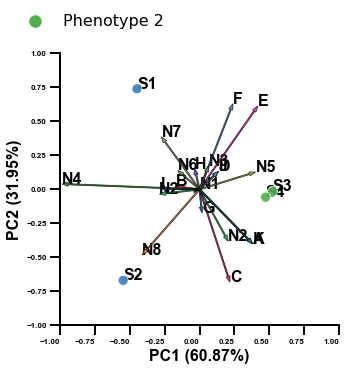

In [10]:
fig, ax = draw_painting_biplot(rpca_res[0], 'PC1', 'PC2')

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
      ax.spines[axis].set_linewidth(2)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=2, length=10)
ax.tick_params(axis='x', colors='black', width=2, length=10)

# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:], loc=2, 
                         bbox_to_anchor=(-0.2, 1.2),
                         prop={'size':16},
                         fancybox=False, framealpha=.0,
                         ncol=7, markerscale=2)
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)

plt.savefig('../../results/figures/biplot-example.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


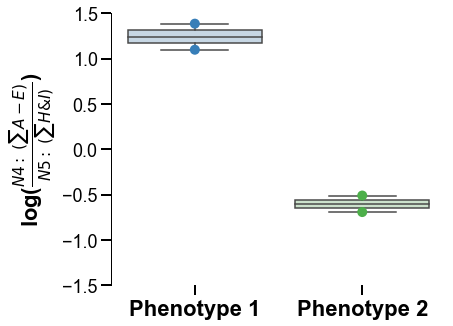

In [13]:
counts_by_node = pd.DataFrame(fu_res[0].T, fu_res[3], sids)

# N4 (sum: A-E) - N5 (sum: H&I)
lr = np.log(counts_by_node.loc['n16',:]) \
    - np.log(counts_by_node.loc['n13',:])
lr = pd.DataFrame(lr, columns=['log-ratio'])

cmap = {'Phenotype 1':'#377eb8',
        'Phenotype 2':'#4daf4a'}
lr['sample_map'] = ['Phenotype 1', 'Phenotype 1',
                   'Phenotype 2', 'Phenotype 2']
 
fig, ax = plt.subplots(1,1, figsize=(6,5))
    
sns.boxplot(y='log-ratio', x='sample_map',  data=lr, palette=cmap)
sns.swarmplot(y='log-ratio', x='sample_map',  data=lr, palette=cmap, s=10)

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['left'].set_bounds(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)


for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=2, length=10)
ax.tick_params(axis='x', colors='black', width=2, length=10)
"""ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")"""
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    #tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(18)
ax.set_xlabel('',
              fontsize=22,
              family = 'arial',
              weight='normal',
              color='black')

ax.set_ylabel('log($\\frac{N4:\,\,(\\sum{A-E})}{N5:\,\,(\\sum{H&I})}$)',
              fontsize=22,
              family = 'arial',
              weight='bold',
              color='black')

plt.savefig('../../results/figures/log-ratio-example.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()
